# Détection de spams

4601 observations, 57 variables (numériques)

Attribute Information:

The last column of 'spambase.data' denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. Most of the attributes indicate whether a particular word or character was frequently occuring in the e-mail. The run-length attributes (55-57) measure the length of sequences of consecutive capital letters. For the statistical measures of each attribute, see the end of this file. Here are the definitions of the attributes:

48 continuous real [0,100] attributes of type word_freq_WORD = percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail. A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string.

6 continuous real [0,100] attributes of type char_freq_CHAR] = percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail

1 continuous real [1,...] attribute of type capital_run_length_average = average length of uninterrupted sequences of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_longest = length of longest uninterrupted sequence of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_total = sum of length of uninterrupted sequences of capital letters = total number of capital letters in the e-mail

1 nominal {0,1} class attribute of type spam = denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail.

source : https://archive.ics.uci.edu/ml/datasets/Spambase

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve, roc_curve
from sklearn import linear_model

## Importation des données

In [2]:
varnames = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names",
                  sep=":",
                  skiprows=33,
                  names = ["name","type"],
                  header=None)
varnames = list(  varnames["name"])+["class"] 

data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data",
                  sep=",",
                  names = varnames,
                  header=None)

data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [3]:
data_np = data.to_numpy()


# Avec sélection de 3 classes
X = data_np[:,:-1]
print("Taille de X : ",X.shape)
Y = data_np[:,-1]
print("Longueur de Y : ", Y.shape)

Taille de X :  (4601, 57)
Longueur de Y :  (4601,)


## Statistiques descriptives

Text(0.5, 1.0, 'Répartition du type de messages')

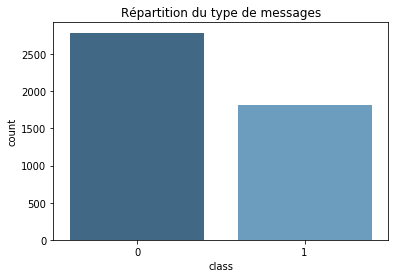

In [4]:
sns.countplot(x="class",data=data,palette="Blues_d")
plt.title("Répartition du type de messages")

Text(0, 0.5, 'PC2 (6.0%)')

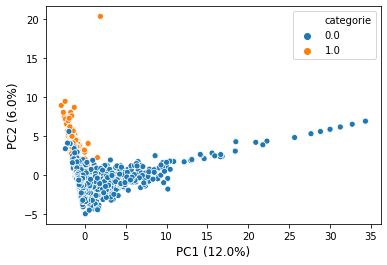

In [5]:
from sklearn.decomposition import PCA


scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

pca = PCA(n_components=2)
pca.fit(X_sc)

PC = pca.transform(X_sc)

d = {'PC1': PC[:,0], 'PC2': PC[:,1], 'categorie':Y}
df = pd.DataFrame(data=d)

sns.scatterplot(x="PC1",y="PC2",hue="categorie",data = df)
plt.xlabel("PC1 ("+str(round(pca.explained_variance_ratio_[0]*100))+"%)" , size = 12 ) 
plt.ylabel( "PC2 ("+str(round(pca.explained_variance_ratio_[1]*100))+"%)"  , size = 12 ) 

Un premier exemple de construction d'un arbre de classification. On commence comme d'habitude à générer un ensemble d'apprentissage et un ensemble de test. L'argument random_state permet de fixer la graine du générateur pseudo-aléatoire. 


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## 1- Arbre de decision 

### 1-1 Ajuster un modèle d'arbre de decision entre X_train et y_train en faisant la validation croisée pour sélectionner les hyperparamètres 
Vous pouvez utiliser la fonction GridSearchCV

In [7]:
######### code ici

### 1-2 Utiliser le modèle pour faire les prédictions et calculer les mesures de perfermances (accuracy, recall, precision, F1 score) et matrice de confusion

In [28]:
######### code ici
pred_tree = ""

## 2 - Forêt aléatoire
### 2-1 Ajuster un modèle de forét aléatoire entre X_train et y_train
Les hyperparamètres important d'une foret aléatoire sont le nombre des variables à considérer pour construire chaque arbre (max_features) et la profondeur max des arbre (max_depth). Normalement les forets aléatoire ne sont pas très sensibles au choix des hyperparamètres. Classiquement, pour la classification le nombre max_features est choisi égale à $\sqrt p$ et $\frac{p}{3}$ dans le cas de la regression. Vous pouvez utiliser la validation croisée pour sélectionner les hyperparamètres, mais ce n'est pas obligatoire!
  


In [18]:
######### code ici

### 2-2 Utiliser le modèle pour faire les prédictions et calculer les mesures de perfermances (accuracy, recall, precision, F1 score) et matrice de confusion

In [29]:
###########code ici   
pred_rf = ""

### 2-3 Récupérer l'importance des variables dans l'attribut feature_importances_

In [ ]:
########## code ici

### 2-4 Trouver l'importance des varaibles en utilisant la méthode de permutation vue dans le cours
Hint: utiliser la fonction permutation_importance dans sklearn.inspection 

In [ ]:
############# code ici

In [ ]:
importances = ### code ici
indices = np.argsort(importances)
plt.figure(figsize=(6,15))
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(X.shape[1]), data.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.show()

### 2-5 Quelle est la difference entre les deux méthodes? 

## 3- Boosting - adaboost

### 3-1 Ajuster un modèle adaboost et sélectionner les hyperparametres (nombres d'estimateurs et taux d'apprentissage)

In [20]:
########## code ici

### 3-2 Utiliser le modèle pour faire les prédictions et calculer les mesures de perfermances (accuracy, recall, precision, F1 score) et matrice de confusion

In [30]:
########## code ici
pred_ada = ""

## 4- Gradient boosting
### 4-1 Ajuster un modèle de gradient boosting et sélectionner les hyperparametres (nombres d'estimateurs et taux d'apprentissage)

In [22]:
######## code ici

### 4-2 Utiliser le modèle pour faire les prédictions et calculer les mesures de perfermances (accuracy, recall, precision, F1 score) et matrice de confusion

In [31]:
######## code ici
pred_gb = ""

## 5- Comparaison des méthodes

### 5-1 Compléter le tableau

| Méthode| accuracy | precision | recall | F1- score|
| :-: | :-:  | :-: |  :-: |  :-: |
| Decision tree | ... | ... |...|...|
| Random forest | ... | ... |...|...|
| Adaboost | ... | ... |...|...|
| Gradient boosting | ... | ... |...|...|

### 5-2 Tracer la courbe ROC des 4 méthodes dans un seul graphique 

Hint: utiliser la fonction roc_curve

In [24]:
######## code ici